# Ptype - ML!

---

## Overview
In this cookbook we will go through a simple example showing the Supervised Machine Learning Framework. 

1. Reading Data and Exploratory Data Analysis
1. Splitting Dataset and Scaling Data
1. Training, Testing, and Validating Model

## Prerequisites



| Concepts | Importance | Notes |
| --- | --- | --- |
| [10 minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html) | Necessary | |
| [Pyplot tutorial](https://matplotlib.org/stable/tutorials/pyplot.html) | Helpful | Necessary |
| [Numpy: the absolute basics for beginners](https://numpy.org/doc/stable/user/absolute_beginners.html) | Great to have | arrays are the language of machine learning |

- **Time to learn**: 

Under an hour. While it can be easy to get started with the scikit learn syntax, 

- **System requirements**:
    - Populate with any system, version, or non-Python software requirements if necessary
    - Otherwise use the concepts table above and the Imports section below to describe required packages as necessary
    - If no extra requirements, remove the **System requirements** point altogether

---

## Imports

Uncomment the below line if you need to install the packages below

In [1]:
# pip install numpy pandas seaborn matplotlib pyarrow

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# needed to read in parquet files
import pyarrow

We will do more imports as they come in the notebook.

## Read in the data

First we will read our data file and examine it's size. We can also read csv files using the `read_csv()` function from pandas.

In [3]:
df = pd.read_parquet(r'../0_data/ptype_sampled.parquet')

In [4]:
memory_in_megabytes = df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"The DataFrame size is: {memory_in_megabytes:.2f} MB")

print('The shape of the Dataframe is ' + str(df.shape))

The DataFrame size is: 0.15 MB
The shape of the Dataframe is (2000, 6)


So we have 2000 rows, and 6 columns

Let's examine the columns of our dataframe:

In [5]:
column_names = df.columns.tolist()
print(column_names)

['TEMP_C_0_m', 'T_DEWPOINT_C_0_m', 'PRES_Pa_0_m', 'UGRD_m/s_0_m', 'VGRD_m/s_0_m', 'ptype']


These names stand for Temperature and Dewpoint Temperature, (both in degrees Celsius), Atmospheric Pressure in Pascals, U and V components of the Wind in meters per second, and finally, Precipitation Type. All of these variables are measured at ground level. 

## Let's do EDA

After we have imported our data, the next step is to explore it. This part is called Exploratory Data Analysis (EDA). The `describe()` function will give us some descriptive statistics about our columns with numeric values.

In [6]:
df.describe()

,TEMP_C_0_m,T_DEWPOINT_C_0_m,PRES_Pa_0_m,UGRD_m/s_0_m,VGRD_m/s_0_m
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,7.191655,4.295661,97771.921875,0.245982,-0.635261
std,11.015690,10.693258,4340.964355,3.244668,3.497571
min,-19.339417,-23.740677,68586.640625,-12.982805,-12.780014
25%,-0.677414,-3.349205,97349.937500,-1.848213,-2.909421
50%,2.912354,0.713211,98749.937500,-0.040516,-0.531640
75%,17.254036,14.244499,100049.683594,2.224049,1.671326
max,33.993225,26.039459,103628.171875,11.791678,11.930449


Take a look at the count row, we have 2000 entries in each column, so there is no missing data! Each variable has different means, but some have different standard deviations. 

It is easier to see the relationship between our variables if we plot them:

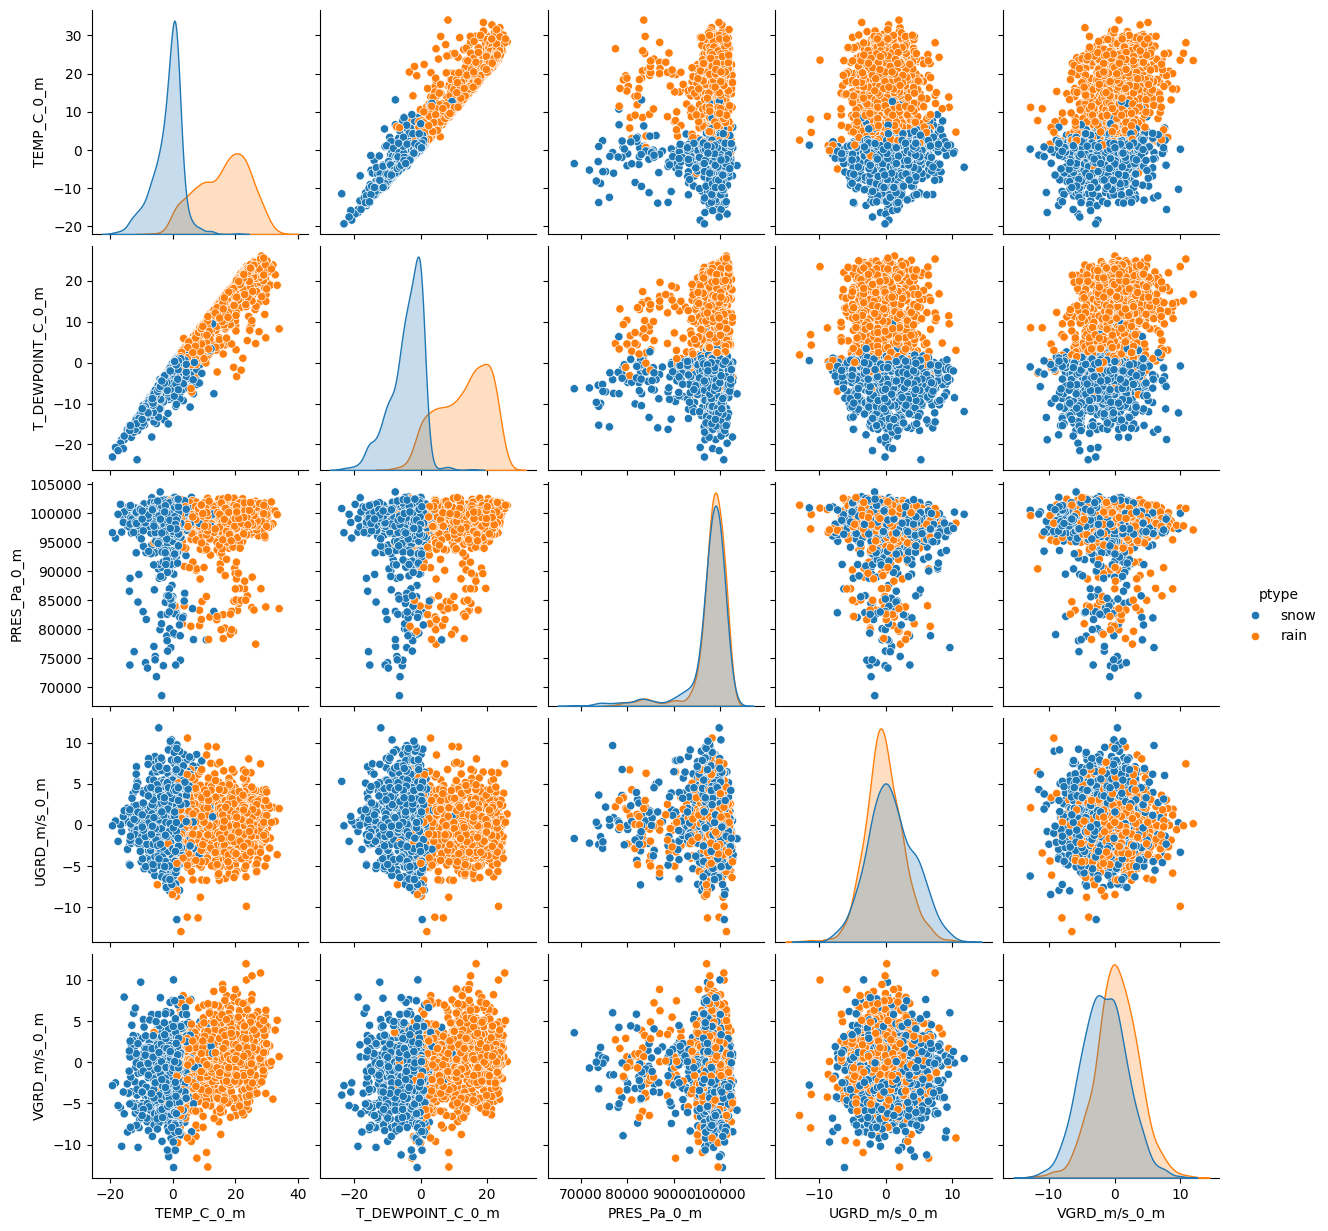

In [7]:
sns.pairplot(df, hue='ptype')

Notice any trends so far? What input features might be the most important? 

Next we can plot the Correlation Matrix. As the name suggests, this will show us the correlation between variables. The closer the absolute value is to 1, the stronger the relationship between these variables is. Notice how all of our diagonal values equal to 1? this is because they represent the correlation between a variable and itself. Can you see which other variables have strong correlations?

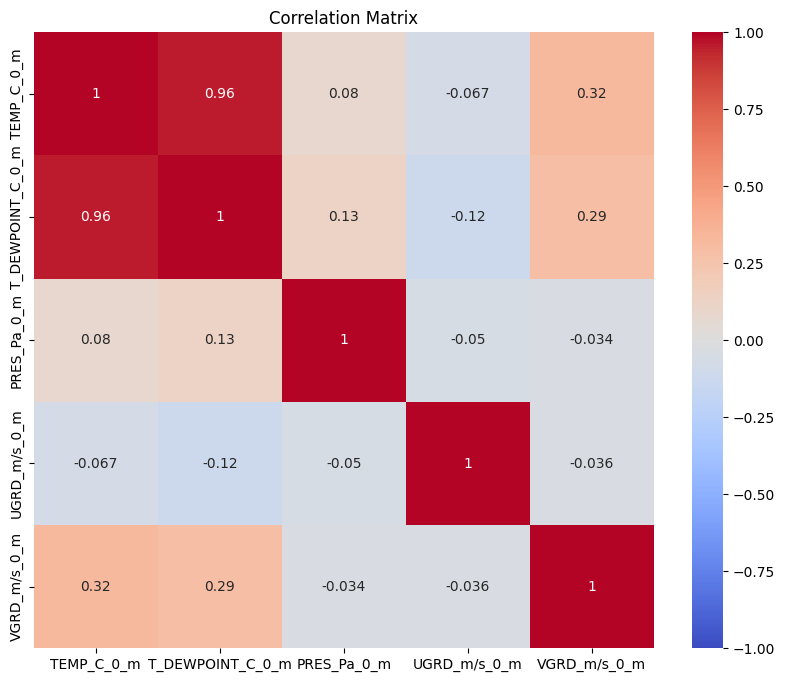

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=['number']).corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

## Splitting Datasets

In this section we will learn how to split our data into the training, validation, and testing sets. As the name suggests, training set is used to teach the model about the data, while validation and testing sets are used to asses the performance of the model. 
To learn more about the differences between the three, read the following article: [What is the Difference Between Test and Validation Datasets?](https://machinelearningmastery.com/difference-test-validation-datasets/) Or browse through this module to also learn more details about the ML framework: [Machine Learning Foundations in the Earth Systems Sciences](https://elearning.unidata.ucar.edu/dataeLearning/Cybertraining/foundations/#/)


In [9]:
from sklearn.model_selection import train_test_split

For this notebook, we will be doing a regression problem. The ptype variable will just be used for EDA. This example uses Temperaturere, Pressure, and Wind Components (x variables) to determine the dewpoint (y variable).

In [10]:
X = df[['TEMP_C_0_m', 'PRES_Pa_0_m','UGRD_m/s_0_m', 'VGRD_m/s_0_m' ]]
y = df['T_DEWPOINT_C_0_m']

In [11]:
# Splitting into training and temporary set (70% training, 30% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Splitting the temporary set into testing and validation sets (20% testing, 10% validation of the original dataset)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

## Scaling Your Data

After we split the data, we must scale it. Scaling helps us make sure all features, or variables, contribute equally to the model. We will be using [scikit-learn's `StandardScaler()` function](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler), which standardizes our features by substracting the mean from each observation and then dividing by the standard deviation.

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
# Initialize the scaler
scaler = StandardScaler()

In the following code, the `fit_transform()` function calculates the mean and standard deviation (fit) of `X_train`, and then uses those parameters to scale the data (transform).

In [14]:
# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing and validation data using the same scaler
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

Notice how we are using `transform()` on our testing and validation data instead. This allows us to use the same mean and invariance as in the training set and keep the testing/validation data "unseen". This last part is especially important to maintain an unbiased model. 

The following article provides a more detailed explanation: [What and why behind fit_transform() and transform() in scikit-learn!](https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe)

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Note</p>
    Always scale datasets after splitting to prevent data leakage!
</div>

## Machine Learning

### Training

This is a simple problem, we can choose logistic regression or support vector machine as our classification model.

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
# Initialize the Logistic Regression model
model = LinearRegression()

In [17]:
# Train the model with the training data
model.fit(X_train_scaled, y_train)

LinearRegression()

Next step, let's use the testing data

In [18]:
# Predicting the Test set results
y_pred = model.predict(X_test_scaled)

### Regression Metrics

In [19]:
from sklearn.metrics import root_mean_squared_error, r2_score

# Calculate RMSE & R2
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE on Test Set: {rmse:.2f}")
print(f"R-squared (R2) on Test Set: {r2:.2f}")

RMSE on Test Set: 3.23
R-squared (R2) on Test Set: 0.91


R-squared (R²) and Root Mean Squared Error (RMSE) are both metrics used to evaluate the performance of regression models, but they convey different types of information. R², also known as the coefficient of determination, measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1, where a higher value indicates a better fit of the model to the data, with 1 representing a perfect fit. RMSE, on the other hand, quantifies the average magnitude of the prediction errors, providing an absolute measure of fit in the same units as the dependent variable. It calculates the square root of the average squared differences between predicted and observed values, with a lower RMSE indicating a model that predicts more accurately. While R² gives a sense of how well the model explains the variability of the data, RMSE provides a direct measure of the model’s prediction accuracy. This [blog post](https://www.unidata.ucar.edu/blogs/news/entry/r-sup-2-sup-downsides) covers some of the downsides to looking at R2 alone.

### Now let's try it on the validation set

At this point we could make some changes to our model based on the metrics we got after testing and repeat the training and testing process. Once we are done we can proceed to validate model:

In [20]:
# Predicting the Validation set results
y_val_pred = model.predict(X_val_scaled)

# Calculate RMSE & R2
rmse_val = root_mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print(f"RMSE on Validation Set: {rmse_val:.2f}")
print(f"R-squared (R2) on Validation Set: {r2_val:.2f}")

RMSE on Validation Set: 2.36
R-squared (R2) on Validation Set: 0.95


## Different dataset, different results?

Let's look at another dataset. This dataset just has snow and freezing rain as the p-types, so overall it will be colder. Let's see if we 

In [21]:
df_frza = pd.read_parquet(r'../0_data/ptype_sampled_frza.parquet')

In [22]:
df_frza.describe()

,TEMP_C_0_m,T_DEWPOINT_C_0_m,PRES_Pa_0_m,UGRD_m/s_0_m,VGRD_m/s_0_m
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-1.224230,-3.480852,97853.976562,-0.276727,-1.568403
std,4.247179,4.457617,4084.320557,3.331565,3.333240
min,-19.303024,-24.025223,67854.320312,-11.178705,-14.452679
25%,-3.115570,-5.516388,97356.414062,-2.465180,-3.786891
50%,-0.692780,-2.609085,98588.738281,-0.602569,-1.692378
75%,0.643044,-0.705284,99923.923828,1.779485,0.665858
max,27.657043,25.156921,103556.835938,16.121258,10.243851


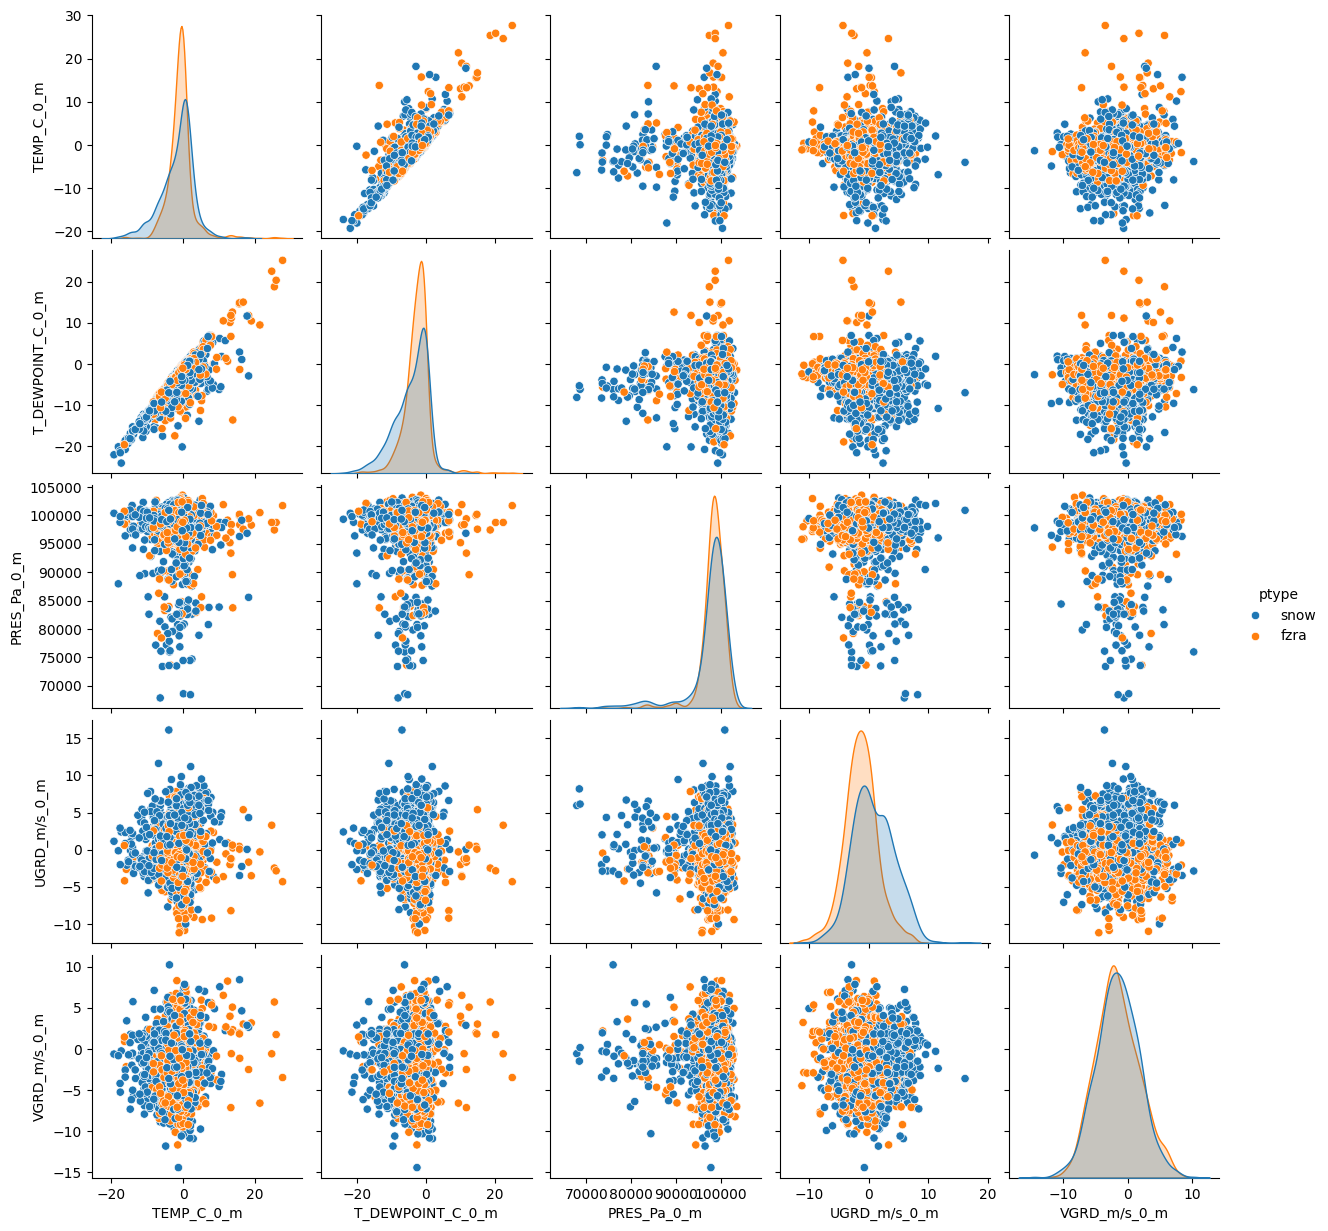

In [23]:
sns.pairplot(df_frza, hue='ptype')

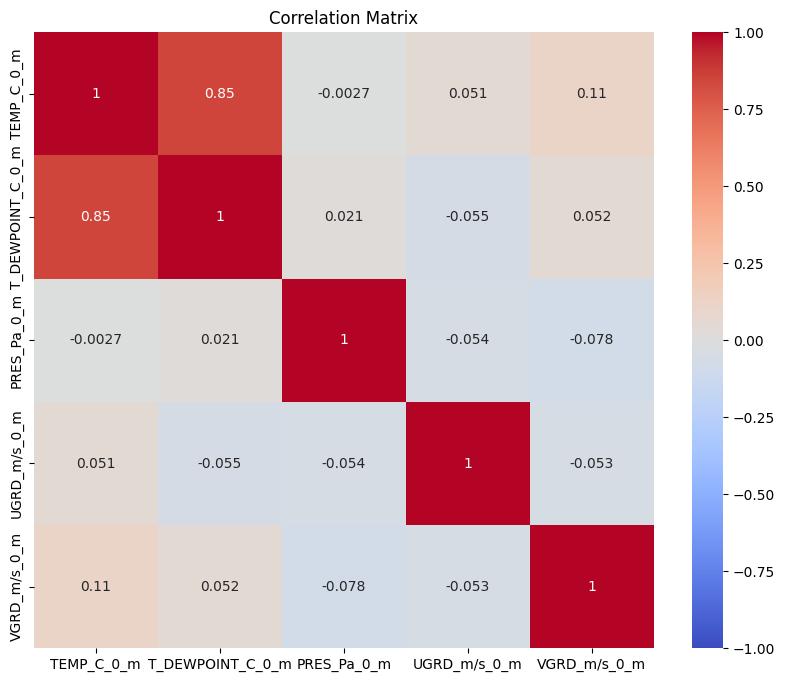

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_frza.select_dtypes(include=['number']).corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

What are the differences in EDA compared to rain vs snow? Do you expect this to do better or worse compared to rain vs snow?

### Split up the data & Scale

The following code is a bit compressed, but is the same line for line as above, just with a new dataset.

In [25]:
X2 = df_frza[['TEMP_C_0_m',  'PRES_Pa_0_m','UGRD_m/s_0_m', 'VGRD_m/s_0_m' ]]
y2 = df_frza['T_DEWPOINT_C_0_m']

In [26]:
# Splitting into training and temporary set (70% training, 30% temporary)
X_train2, X_temp2, y_train2, y_temp2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

# Splitting the temporary set into testing and validation sets (20% testing, 10% validation of the original dataset)
X_test2, X_val2, y_test2, y_val2 = train_test_split(X_temp2, y_temp2, test_size=1/3, random_state=42)

In [27]:
# Initialize the scaler
scaler = StandardScaler()

In [28]:
# Fit the scaler to the training data and transform it
X_train_scaled2 = scaler.fit_transform(X_train2)

# Transform the testing and validation data using the same scaler
X_test_scaled2 = scaler.transform(X_test2)
X_val_scaled2 = scaler.transform(X_val2)

In [29]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()

In [30]:
# Train the model with the training data
model.fit(X_train_scaled2, y_train2)

DecisionTreeRegressor()

### Test Set ML

In [31]:
# Predicting the Test set results
y_pred2 = model.predict(X_test_scaled2)

In [32]:
rmse = root_mean_squared_error(y_test2, y_pred2)
r2 = r2_score(y_test2, y_pred2)

print(f"RMSE on Test Set: {rmse:.2f}")
print(f"R-squared (R2) on Test Set: {r2:.2f}")

RMSE on Test Set: 2.77
R-squared (R2) on Test Set: 0.59


### Validation Set ML 

In [33]:
# Predicting the Validation set results
y_val_pred2 = model.predict(X_val_scaled2)

# Calculate RMSE & R2
rmse_val = root_mean_squared_error(y_val2, y_val_pred2)
r2_val = r2_score(y_val2, y_val_pred2)

print(f"RMSE on Validation Set: {rmse_val:.2f}")
print(f"R-squared (R2) on Validation Set: {r2_val:.2f}")

RMSE on Validation Set: 2.76
R-squared (R2) on Validation Set: 0.65


### More Questions

1. What do you see comparing the metrics; freezing rain vs snow and snow vs rain? Is this what you expected?
   
1. Is the Decision Tree model consistent between testing and validations sets for both experiments? Could we potentially use a more complex model?
   
1. How many lines of code does it take to do a quick ML analysis with a testing, training, and validation dataset?

---

## Summary
In this notebook we learned:
1. What Exploratory Data Analysis is and some useful functions that can help you in the process of understading your data.
1. How and why we split and scale data
1. How to train your model and evaluate its accuracy afterwards

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
1. [What is the Difference Between Test and Validation Datasets?](https://machinelearningmastery.com/difference-test-validation-datasets/)
1. [Machine Learning Foundations in the Earth Systems Sciences](https://elearning.unidata.ucar.edu/dataeLearning/Cybertraining/foundations/#/)
1. [Scikit-learn's StandardScaler Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
1. [What and why behind fit_transform() and transform() in scikit-learn!](https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe)